# PCA on Marker genes

In [1]:
import pandas as pd
import pickle
import numpy as np

In [2]:
with open("marker_genes.pkl", 'rb') as f:
    marker_genes = pickle.load(f)

In [4]:
expressions_df = pd.read_csv("gene_expression_original.csv", sep='\t', index_col=0)

In [5]:
expressions_df = expressions_df.loc[marker_genes, :]

In [9]:
expressions_df.drop("Gene", axis=1, inplace=True)

In [12]:
expressions_df = expressions_df.transpose()

In [14]:
expressions_df = np.log10(expressions_df)

In [15]:
import re
def extract_number(mystring):
    numbers = re.findall("^\d+", mystring)
    return int(numbers[0])

In [33]:
months = np.array([extract_number(timepoint) for timepoint in expressions_df.index.tolist()])

In [18]:
expressions_mat = expressions_df.to_numpy()

In [19]:
# standarize each column
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_expression = scaler.fit_transform(expressions_mat)

In [21]:
np.std(scaled_expression, axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

In [22]:
from sklearn.decomposition import PCA

In [57]:
pca = PCA(n_components=10)
pca.fit(scaled_expression)
transformed_expression = pca.transform(scaled_expression)

In [58]:
pca.explained_variance_ratio_

array([0.50920119, 0.11890017, 0.10664254, 0.06420162, 0.0469697 ,
       0.03266665, 0.0246524 , 0.01594771, 0.01417407, 0.01333329])

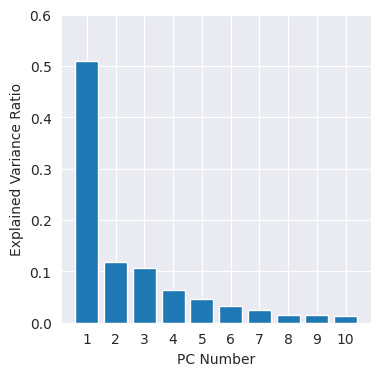

In [60]:
import matplotlib.pyplot as plt
fig0, ax0 = plt.subplots(figsize=(4, 4))
ax0.bar(np.arange(1, 11), pca.explained_variance_ratio_)
ax0.set_xticks(np.arange(1, 11))
ax0.set_ylim([0, 0.6])
ax0.set_xlabel('PC Number')
ax0.set_ylabel('Explained Variance Ratio')
fig0.savefig('modeling/PCA_variance_ratio.png', dpi=400, bbox_inches='tight')

In [49]:
# time_str = months.astype(str)
unique_time = np.unique(months)

In [50]:
unique_time

array([ 2,  4,  6,  8, 10, 12, 13, 15, 17, 18, 21, 23])

In [51]:

# color scheme
color_map = {cat: plt.get_cmap('tab20')(i) for i, cat in enumerate(unique_time)}
colors = [color_map[cat] for cat in months]

/tmp/ipykernel_24303/3518457479.py:4: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=color_map[month], label=str(month))


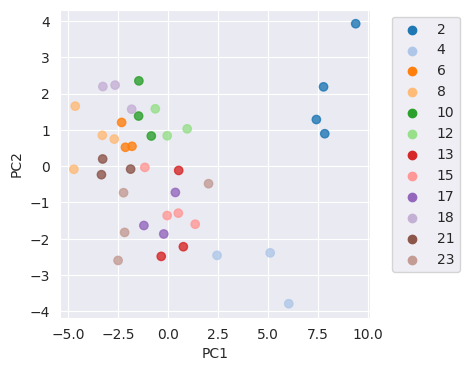

In [61]:
fig1, ax1 = plt.subplots(figsize=(4, 4))
ax1.scatter(transformed_expression[:, 0], transformed_expression[:, 1], c=colors, alpha=0.8)
for month in unique_time:
    plt.scatter([], [], c=color_map[month], label=str(month))
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
fig1.savefig("modeling/PCA_all.png", dpi=400, bbox_inches='tight')


My next step is to carry out leave one out analysis.

In [63]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA())
])

In [88]:
pca_prediction = np.zeros((expressions_mat.shape[0], 4))
pca_prediction[:, 0] = months

In [91]:

for i in range(expressions_mat.shape[0]):
    loo_index = i
    mask = np.ones(expressions_mat.shape[0], dtype=bool)
    mask[loo_index] = False
    train_mat = expressions_mat[mask, :]
    test_mat = expressions_mat[loo_index, :].reshape(1, -1)
    months_train = months[mask]
    true_month = months[loo_index]

    pipeline.fit(train_mat)
    train_transformed = pipeline.transform(train_mat)
    test_transformed = pipeline.transform(test_mat)

    # first two coordinates
    train_coords = train_transformed[:, :2]
    test_coords = test_transformed[:, :2]

    distance = np.sum((train_coords - test_coords)**2, axis=1)

    indices_sorted = np.argsort(distance)
    smallest_three_indices = indices_sorted[:3]

    pca_prediction[i, 1:] = months_train[smallest_three_indices]


In [93]:
unique_time

array([ 2,  4,  6,  8, 10, 12, 13, 15, 17, 18, 21, 23])

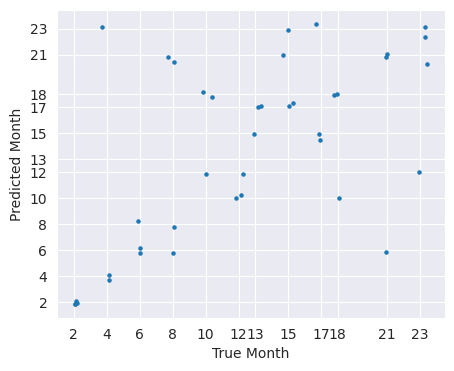

In [100]:
fig3, ax3 = plt.subplots(figsize=(5, 4))

xval = pca_prediction[:, 0] + np.random.normal(0, 0.2, pca_prediction.shape[0])
yval = pca_prediction[:, 1] + np.random.normal(0, 0.2, pca_prediction.shape[0])

ax3.scatter(xval, yval, s=5)
ax3.set_xlabel("True Month")
ax3.set_ylabel("Predicted Month")
ax3.set_xticks(unique_time)
ax3.set_yticks(unique_time)
fig3.savefig("modeling/PCA_performance.png", dpi=400, bbox_inches='tight')

In [101]:
np.mean(pca_prediction[:, 0] == pca_prediction[:, 1])

0.4

In [104]:
equal_1 = pca_prediction[:, 0] == pca_prediction[:, 1]
equal_2 = pca_prediction[:, 0] == pca_prediction[:, 2]
equal_3 = pca_prediction[:, 0] == pca_prediction[:, 3]

In [106]:
equal_1 + equal_2 + equal_3

array([ True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False, False, False,  True,  True,  True, False,
       False, False,  True,  True,  True, False, False,  True,  True,
        True,  True, False, False])

In [112]:
pca_prediction_df = pd.DataFrame(data=pca_prediction, columns=["Real", "First", "Second", "Third"])
pca_prediction_df.to_csv("modeling/PCA_performance.csv", index=False)